Aluno: Rodrigo Braz 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")


In [29]:
def cross_validation_split(data, n_folds):
    fold_size = len(data) // n_folds
    indices = np.random.permutation(len(data))
    folds = []
    for i in range(n_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i < n_folds - 1 else len(data)
        fold_indices = indices[start:end]
        fold = data.iloc[fold_indices]
        folds.append(fold)
    return folds


In [30]:

# Implementação do processo de boosting
def train_boosted_classifier(data, target, n_iterations):
    n_samples, n_features = data.shape
    weights = np.ones(n_samples) / n_samples
    classifiers = []
    alpha_values = []

    # Converter os valores da coluna de destino em números
    target_values = np.where(target == 'positive', 1, -1)

    for _ in range(n_iterations):
        classifier = DecisionTreeClassifier(max_depth=1)
        classifier.fit(data, target_values, sample_weight=weights)
        predictions = classifier.predict(data)
        errors = np.sum(weights * (predictions != target_values))

        if errors > 0.5:
            break

        alpha = 0.5 * np.log((1 - errors) / errors)
        weights *= np.exp(-alpha * target_values * predictions)
        weights /= np.sum(weights)

        # Tratar divisões por zero
        weights = np.where(np.isnan(weights), 0, weights)

        classifiers.append(classifier)
        alpha_values.append(alpha)

    return classifiers, alpha_values




In [31]:
# Função para calcular a taxa de erro média
def calculate_mean_error(folds, n_iterations):
    errors = []
    for i in range(len(folds)):
        train_folds = [fold for j, fold in enumerate(folds) if j != i]
        train_data = pd.concat(train_folds)
        test_data = folds[i]

        classifiers, alpha_values = train_boosted_classifier(train_data.iloc[:, :-1], train_data.iloc[:, -1],
                                                            n_iterations)

        predictions = np.zeros(len(test_data))
        for classifier, alpha in zip(classifiers, alpha_values):
            predictions += alpha * classifier.predict(test_data.iloc[:, :-1])

        predictions = np.sign(predictions)
        errors.append(np.sum(predictions != np.where(test_data.iloc[:, -1] == 'positive', 1, -1)) / len(test_data))

    mean_error = np.mean(errors)
    return mean_error, errors




In [32]:
# Função para comparar taxas de erro em diferentes números de iterações
def compare_errors(data, target, n_folds, max_iterations):
    folds = cross_validation_split(data, n_folds)
    error_rates = []

    for n_iterations in range(1, max_iterations + 1):
        mean_error, _ = calculate_mean_error(folds, n_iterations)
        error_rates.append(mean_error)

    return error_rates



In [33]:

# Função para gerar um gráfico comparando taxas de erro
def plot_error_comparison(error_rates):
    iterations = range(1, len(error_rates) + 1)
    plt.plot(iterations, error_rates, marker='o')
    plt.xlabel('Número de Iterações')
    plt.ylabel('Taxa de Erro Média')
    plt.title('Comparação de Taxas de Erro')
    plt.show()




In [34]:
# Função para gerar um gráfico mostrando as taxas de erro em cada fold
def plot_fold_errors(errors):
    folds = range(1, len(errors) + 1)
    plt.bar(folds, errors)
    plt.xlabel('Fold')
    plt.ylabel('Taxa de Erro')
    plt.title('Taxa de Erro por Fold')
    plt.show()




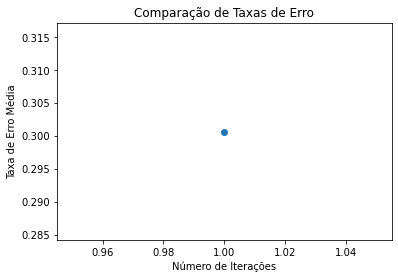

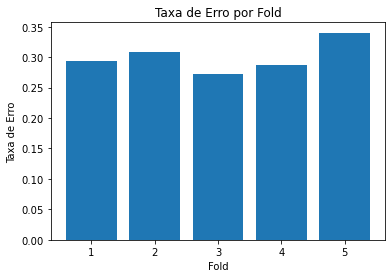

Taxa de erro média: 0.3005019700976953


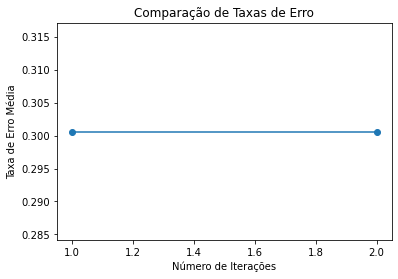

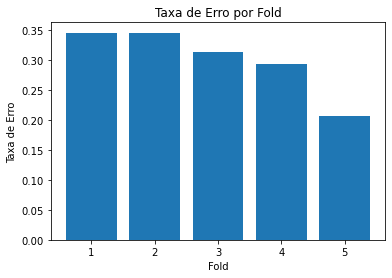

Taxa de erro média: 0.3009229772764074


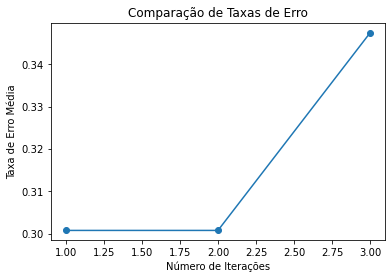

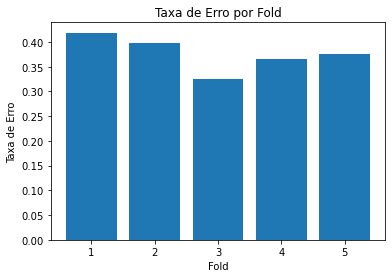

Taxa de erro média: 0.37682841258703514


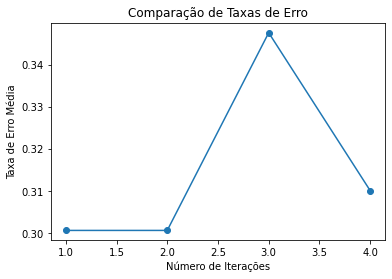

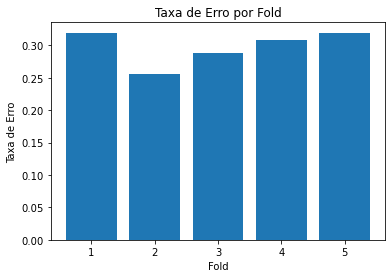

Taxa de erro média: 0.2984724995951854


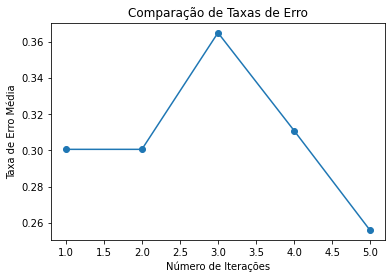

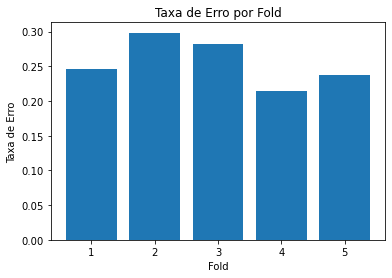

Taxa de erro média: 0.2557996437631565


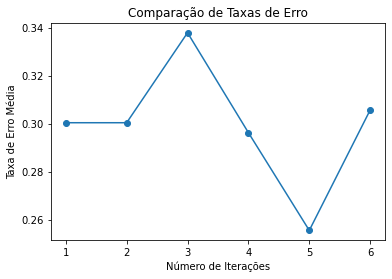

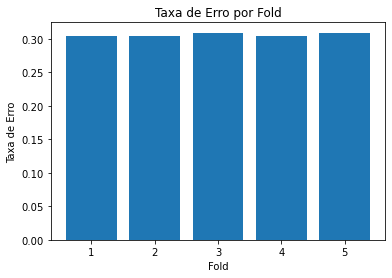

Taxa de erro média: 0.3058347276947158


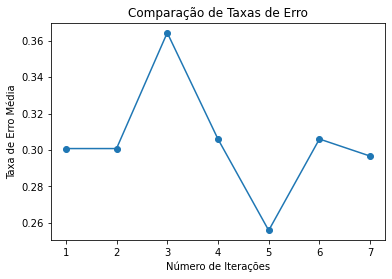

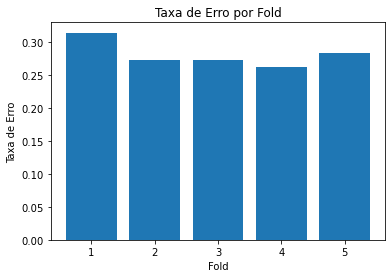

Taxa de erro média: 0.28078480056134286


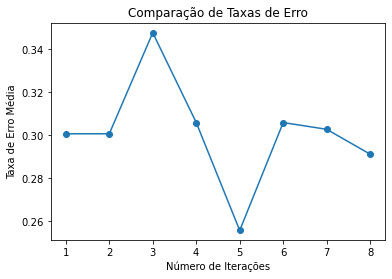

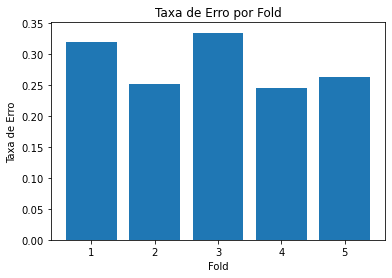

Taxa de erro média: 0.2829438117342257


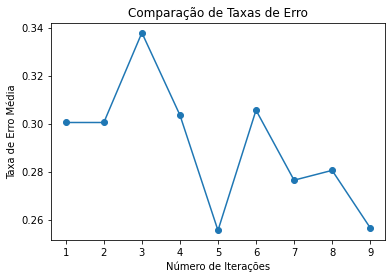

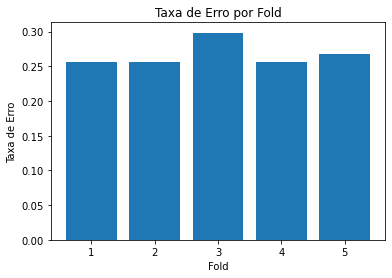

Taxa de erro média: 0.2672208128677066


In [35]:
data = pd.read_csv('tic-tac-toe-endgame.csv')

# Realizar a codificação one-hot dos atributos categóricos
categorical_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))
data = pd.concat([encoded_df, data.drop(categorical_cols, axis=1)], axis=1)
for max_iterations in range(1, 10):
    n_folds = 5

    # Comparação de taxas de erro
    error_rates = compare_errors(data, data.iloc[:, -1], n_folds, max_iterations)

    # Plotagem dos gráficos
    plot_error_comparison(error_rates)
    mean_error, errors = calculate_mean_error(cross_validation_split(data, n_folds), max_iterations)
    plot_fold_errors(errors)
    print("Taxa de erro média:", mean_error)